<a href="https://colab.research.google.com/github/MeetBagda/movie-review-sentiment-rnn/blob/main/Movie_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [9]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/IMDB-Dataset.csv', names=["text","label"], header=0)

df['text'] = df['text'].str.lower().str.split()

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

vocab = {word for phrase in df['text'] for word in phrase}
word_to_idx = {word: idx for idx, word in enumerate(vocab, start=1)}

max_length = df['text'].str.len().max()

def encode_and_pad(text):
    encoded = [word_to_idx[word] for word in text]
    return encoded + [0] *   (max_length - len(encoded))

train_data['text'] = train_data['text'].apply(encode_and_pad)
test_data['text'] = test_data['text'].apply(encode_and_pad)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df

,text,label
0,"[one, of, the, other, reviewers, has, mentione...",1
1,"[a, wonderful, little, production., <br, /><br...",1
2,"[i, thought, this, was, a, wonderful, way, to,...",1
3,"[basically, there's, a, family, where, a, litt...",0
4,"[petter, mattei's, ""love, in, the, time, of, m...",1
...,...,...
49995,"[i, thought, this, movie, did, a, down, right,...",1
49996,"[bad, plot,, bad, dialogue,, bad, acting,, idi...",0
49997,"[i, am, a, catholic, taught, in, parochial, el...",0
49998,"[i'm, going, to, have, to, disagree, with, the...",0


In [6]:
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['text'].values
        self.labels = data['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text =  self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:,-1,:])
        return out

vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
output_size = 2
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")
model = model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\n🚀 Starting Epoch {epoch+1}/{num_epochs}", flush=True)  # 👈 Add this line

    model.train()
    epoch_loss = 0
    for i, (texts, labels) in enumerate(train_loader):
        if i % 50 == 0:
            print(f"Batch {i}/{len(train_loader)} loaded")

        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate the average loss for the current epoch after the inner loop finishes
    avg_loss = epoch_loss / len(train_loader)

    # Print the average loss for the epoch
    print(f'✅ Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}', flush=True)


Using GPU: Tesla T4

🚀 Starting Epoch 1/10
Batch 0/1250 loaded
Batch 50/1250 loaded
Batch 100/1250 loaded
Batch 150/1250 loaded
Batch 200/1250 loaded
Batch 250/1250 loaded
Batch 300/1250 loaded
Batch 350/1250 loaded
Batch 400/1250 loaded
Batch 450/1250 loaded
Batch 500/1250 loaded
Batch 550/1250 loaded
Batch 600/1250 loaded
Batch 650/1250 loaded
Batch 700/1250 loaded
Batch 750/1250 loaded
Batch 800/1250 loaded
Batch 850/1250 loaded
Batch 900/1250 loaded
Batch 950/1250 loaded
Batch 1000/1250 loaded
Batch 1050/1250 loaded
Batch 1100/1250 loaded
Batch 1150/1250 loaded
Batch 1200/1250 loaded
✅ Epoch [1/10] completed, Average Loss: 0.6965

🚀 Starting Epoch 2/10
Batch 0/1250 loaded
Batch 50/1250 loaded
Batch 100/1250 loaded
Batch 150/1250 loaded
Batch 200/1250 loaded
Batch 250/1250 loaded
Batch 300/1250 loaded
Batch 350/1250 loaded
Batch 400/1250 loaded
Batch 450/1250 loaded
Batch 500/1250 loaded
Batch 550/1250 loaded
Batch 600/1250 loaded
Batch 650/1250 loaded
Batch 700/1250 loaded
Batch 75

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 50.39%


Epoch [1/10], Loss: 0.6987
Epoch [2/10], Loss: 0.6980
Epoch [3/10], Loss: 0.6987
Epoch [4/10], Loss: 0.6976
Epoch [5/10], Loss: 0.6974
Epoch [6/10], Loss: 0.6981
Epoch [7/10], Loss: 0.6976
Epoch [8/10], Loss: 0.6980
Epoch [9/10], Loss: 0.6979
Epoch [10/10], Loss: 0.6970


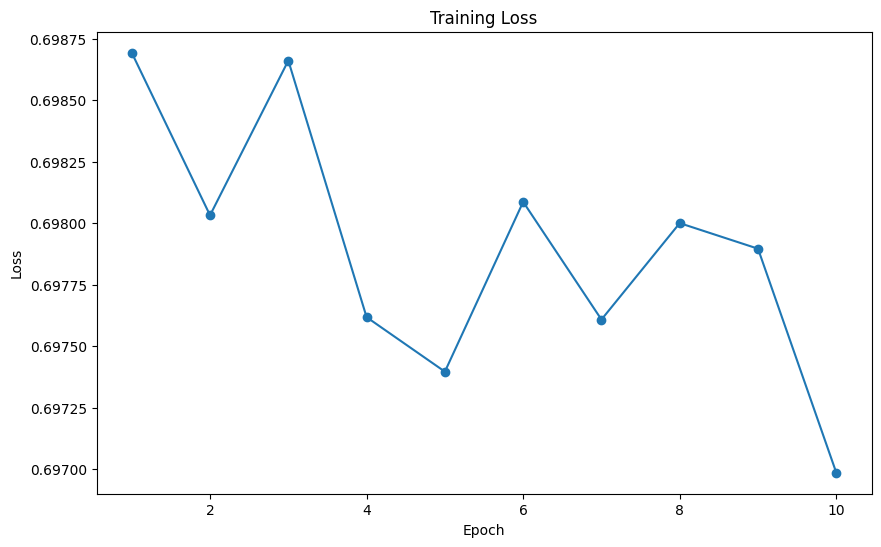

In [16]:
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss / len(train_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()